Hunter S. DiCicco

with Dr. Dongwon Lee, Ph.D.

# Multinomial SVC for Categories of News

## Diagnostics to Assess Model Performance

### Setup and Imports

In [1]:
import pickle
import glob
import copy
import sys
import os

from itertools import combinations
from subprocess import Popen

from sklearn.model_selection import KFold, ShuffleSplit, ParameterSampler, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, make_scorer
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.svm import SVC

#from scipy.stats.distributions import expon, norm

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

os.chdir("../")

import feature_extraction

from validator import get_statistics, validate

def main():
    """
    Instead of an import, we wrap the execution of both of these vital modules within `exec`.
    This ensures that changes are enacted on every chunk evaluation.
    """
    exec(open("classifier.py").read(), globals())
    #exec(open("validator.py").read(), globals())

main()
random_state = 4261998

Retrieving data...
Retrieving data...
Retrieving data...
Retrieving data...
------------
recall:[0.7  0.88 0.03 0.29 0.89]
precision:[0.82 0.84 0.54 0.23 0.51]
f1:[0.75 0.86 0.06 0.26 0.65]
------------

{1: 68, 2: 28, 3: 217, 5: 158, 7: 24}
This model got 55.8% correct || 625 out of 1120.
False negatives for real data (1)
{5: 55, 2: 13}
False negatives for fake data (2)
{5: 28}
False negatives for opinion data (3)
{5: 144, 2: 8, 1: 12, 7: 53}
False negatives for polarized data (5)
{7: 139, 3: 4, 2: 15}
False negatives for satire data (7)
{1: 22, 3: 2}


In [2]:
def load_latest_model(kernel=''):
    """
    Loads and returns the latest model from the `models` directory with the user-specified kernel.
    """
    #cwd = os.getcwd()
    # obtain a glob of the files in the `models` directory
    list_of_files = glob.glob(f"models/*{kernel}*.pickle")

    # obtain the model which was created most recently
    # using the sorting key of creation time
    latest_model = max(list_of_files, key=os.path.getctime)

    # open the most recent model and load it into the namespace
    # WARNING: only load pickle files that you trust! do not allow arbitrary execution
    with open(latest_model, mode="rb") as filein:
        model = pickle.load(filein)
    #os.chdir(cwd)
    return model

## Feature Selection

NOTES: *Some of the insights on linear feature importance used below obtained from [here](https://stackoverflow.com/a/22831491).*

*`plot_coefficients` method initially obtained from [here](https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d)*

In the next chunk we will use our models' support vectors to perform feature selection.

Each feature included in the SVM's training is assigned associated vector(s) of *weight coefficients* which encode that feature's influence on assigning class label(s) during inference. Specifically in the multinomial case, each feature will have many weight vectors since we use the one-versus-rest strategy to find one separating hyperplane per class.

The rows of the weight matrix describe the feature weights for each of the separation problems, which can be written as the mathematical combinations of each of the class labels with the others:

```
weights for 1 vs 2 hyperplane
weights for 1 vs 3 hyperplane
...
weights for 2 vs 3 hyperplane
weights for 2 vs 4 hyperplane
...
weights for 4 vs 5 hyperplane
weights for 5 vs 7 hyperplane
```

We can also compute the *vector norm* of each feature-weight vector to get a heuristic sense (**not** a direct measurement) of overall feature variance in the trained model. The greater a feature's empirical sample variance, the greater it will contribute to weight updates on each training epoch.

One final area of examination would be the model's trained *dual coefficients*, which are out of the author's scope and would require further research.

In summary we should prune those features which have near-zero contribution according to the weights, as well as those that have very little overall feature-weight variance.

Viewing the weight coefficients superimposed on each other in feature space as well as the overall feature-weight variances would give us a great idea as to which features contribute to which inference results. Let's build those visualizations now:

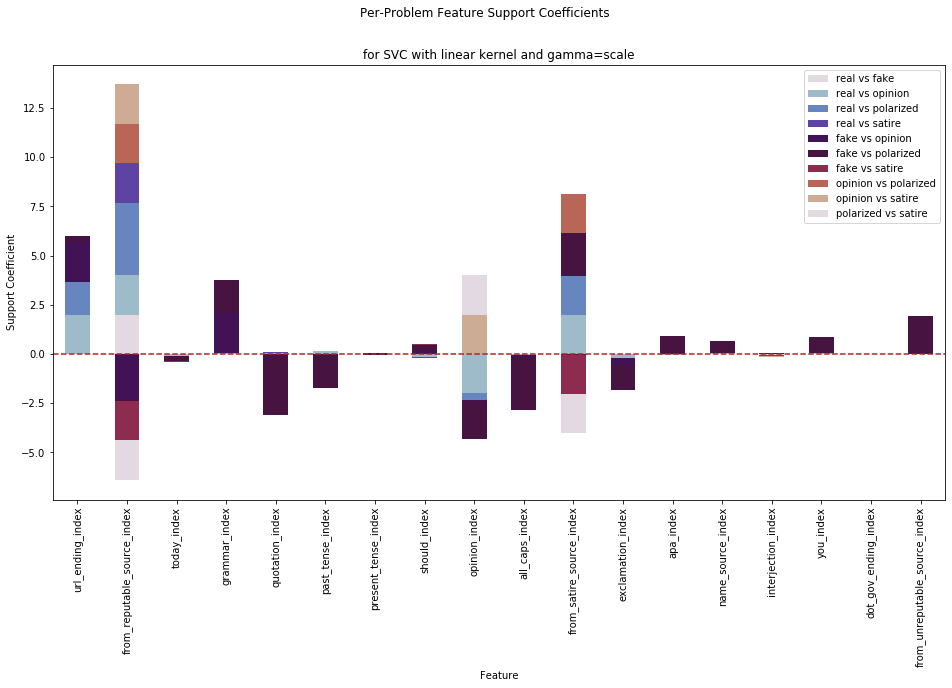

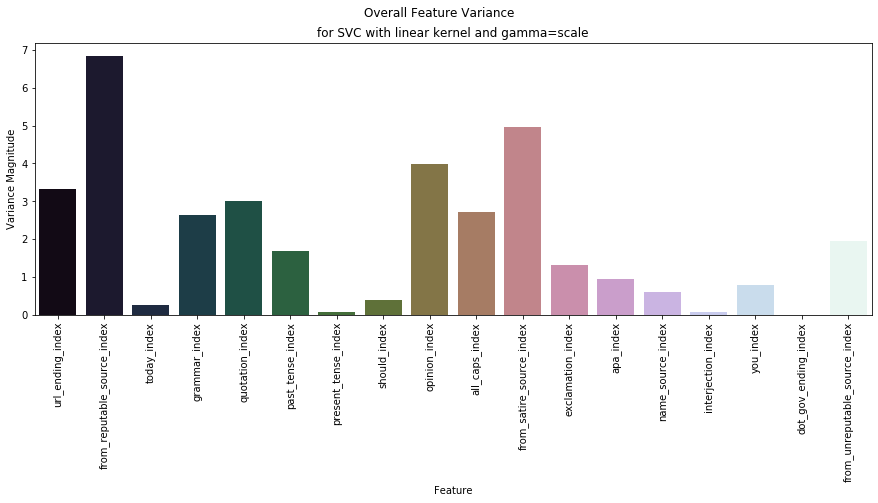

In [3]:
# list of features in use
xlab = ["url_ending_index", "from_reputable_source_index",
        "today_index", "grammar_index", "quotation_index",
        "past_tense_index", "present_tense_index", "should_index",
        "opinion_index", "all_caps_index", "from_satire_source_index",
        "exclamation_index", "apa_index", "name_source_index",
        "interjection_index", "you_index", "dot_gov_ending_index",
        "from_unreputable_source_index"]

# load latest linear model
model = load_latest_model(kernel='linear')

# we are only writing procedures for linear and rbf
# linear has easy-to-interpret feature-weight calculations
# and rbf has a well-established process to make them simpler to interpret
if not model.kernel in ("linear", "rbf"):
    raise AttributeError('Initial model kernel is not linear. Only linear kernels have dual coefficients for class support weights.')

def plot_coefficients(classifier, feature_names, top_features=20):
    """
    Method Docstring Placeholder
    """
    # extract class labels and cardinality of such
    classes = classifier.classes_
    n_classes = len(classes)

    classdict = dict(zip(classes, ('real', 'fake', 'opinion', 'polarized', 'satire')))
    classes = [classdict[j] for _, j in enumerate(classes)]

    # use np.combinations to create a list
    # of the pair combinations of class labels
    classes = list(combinations(classes, 2))

    # coerce the weight coefficient matrix to a pandas dataframe
    # for utility
    coef = pd.DataFrame(classifier.coef_, columns=feature_names)
    
    # we must transpose `coef` to plot it in feature space
    ax = coef.T.plot(kind="bar",
                stacked=True,
                figsize=(16,8),
                colormap="twilight",
                title=f"for SVC with {classifier.kernel} kernel and gamma={classifier.gamma!s}")

    # now we need a handle for the plot's legend
    # in order to correctly label the separation problems
    legend = ax.get_legend()

    # the i'th patch label in the legend
    # should contain the items of the combination pairs
    for i, label in enumerate(legend.get_texts()):
        label.set_text(f"{classes[i][0]!s} vs {classes[i][1]!s}")

    # a line at the origin to create a visual anchor
    plt.axhline(linestyle='dashed', color='firebrick')

    # setting axis labels, over-title and saving the figure
    ax.set(xlabel="Feature", ylabel="Support Coefficient")
    plt.suptitle("Per-Problem Feature Support Coefficients")
    plt.savefig("featureselection_1.png")

plot_coefficients(model, xlab, top_features=18)

# obtain the number of classes
# as well as weights for supports of each class
(n_classes, coefs) = *(len(model.classes_), model.coef_.transpose()),

# take the vector norm ([x dot x]^(1/2)) of each feature-weight vector (axis 1)
coefs = np.apply_along_axis(lambda x: np.sqrt(x.dot(x)), 1, coefs)

### plotting
plt.figure(figsize=(15,5))
# using seaborn for utility
ax = sns.barplot(xlab, coefs, palette=sns.color_palette("cubehelix", len(xlab)))
ax.set_title(f"for SVC with {model.kernel} kernel and gamma={model.gamma!s}")
plt.suptitle("Overall Feature Variance")
ax.set_xticklabels(xlab, rotation=90)
ax.set(xlabel='Feature', ylabel='Variance Magnitude')
plt.savefig("featureselection_2.png")
###

# each vector in the list below represents the support vectors for 
#coefs = model.dual_coef_

### Subset of Robust-Feature Data

#### Hand Selection Based on Visualization

In [4]:
os.chdir("data")

##TODO: Major cleanup in this chunk.

features_to_ablate = ['today_index',
                      'present_tense_index',
                      'should_index',
                      'apa_index',
                      'interjection_index',
                      'you_index',
                      'dot_gov_ending_index']

d_real_train = pd.read_csv("real_news_vectors-training.txt", delim_whitespace=True, names=xlab)
d_real_test = pd.read_csv("real_news_vectors-testing.txt", delim_whitespace=True, names=xlab)
d_fake_train = pd.read_csv("fake_news_vectors-training.txt", delim_whitespace=True, names=xlab)
d_fake_test = pd.read_csv("real_news_vectors-testing.txt", delim_whitespace=True, names=xlab)
d_pol_train = pd.read_csv("polarized_news_vectors-training.txt", delim_whitespace=True, names=xlab)
d_pol_test = pd.read_csv("polarized_news_vectors-testing.txt", delim_whitespace=True, names=xlab)
d_opin_train = pd.read_csv("opinion_vectors-training.txt", delim_whitespace=True, names=xlab)
d_opin_test = pd.read_csv("opinion_vectors-testing.txt", delim_whitespace=True, names=xlab)
d_sat_train = pd.read_csv("satire_vectors-training.txt", delim_whitespace=True, names=xlab)
d_sat_test = pd.read_csv("satire_vectors-testing.txt", delim_whitespace=True, names=xlab)

d_real_full = pd.concat([d_real_train, d_real_test])
d_fake_full = pd.concat([d_fake_train, d_fake_test])
d_pol_full = pd.concat([d_pol_train, d_pol_test])
d_opin_full = pd.concat([d_opin_train, d_opin_test])
d_sat_full = pd.concat([d_sat_train, d_sat_test])

# set the labels for each of the respective full datasets to their given number
# real = 1
# fake = 2
# opinion = 3 and so on
d_real_full['label'], d_fake_full['label'], d_opin_full['label'], d_pol_full['label'], d_sat_full['label'] = *(1, 2, 3, 5, 7),

d_full = pd.concat([d_real_full, d_fake_full, d_opin_full, d_pol_full, d_sat_full])

del d_real_full, d_fake_full, d_pol_full, d_opin_full, d_sat_full
del d_real_train, d_real_test, d_pol_train, d_pol_test, d_opin_train, d_opin_test, d_sat_train, d_sat_test

os.chdir("../")

# hand selection
d_subset_robust = d_full.drop(features_to_ablate, axis=1)

kf = KFold(n_splits=20, shuffle=True, random_state=random_state)

x, y = *(d_subset_robust[d_subset_robust.columns.difference(['label'])].to_numpy(),
         d_subset_robust.iloc[:,-1].to_numpy()),

#param_grid = {'kernel': ['rbf', 'linear'], 'C': expon()}
#sampler = ParameterSampler()

c_s = np.linspace(0.1, 8, 25)

splits = kf.split(x,y)

models, scorestats = {}, pd.DataFrame()

# report mean macroaverage for each fold
for fold_i, (train, test) in enumerate(splits):
    x_train, y_train = x[train], y[train]
    x_test, y_test = x[test], y[test]
    model = SVC(C=2.075, kernel='rbf', gamma='scale', random_state=random_state).fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = recall_score(y_test, y_pred, average='micro')
    scorestats = scorestats.append(get_statistics(y_test, y_pred));
    models.update({model:score})
    validate(model, x_test, y_test);

best_model = max(models, key=models.get)

print(f"Mean Class Recall Across {kf.n_splits!s} Folds: {*scorestats.apply(lambda x: np.round(np.mean(x), 3)),!s}")

with open(f"models/model_kernel[{best_model.kernel}]gamma[{best_model.gamma}]_subset.pickle", mode="wb") as fileout:
    pickle.dump(best_model, fileout)


{2: 12}
This model got 97.71% correct || 512 out of 524.
{2: 10}
This model got 98.09% correct || 514 out of 524.
{2: 10}
This model got 98.09% correct || 514 out of 524.
{2: 11}
This model got 97.9% correct || 513 out of 524.
{2: 10, 3: 1}
This model got 97.9% correct || 513 out of 524.
{2: 18, 3: 1}
This model got 96.37% correct || 505 out of 524.
{2: 11}
This model got 97.9% correct || 513 out of 524.
{2: 13, 7: 1}
This model got 97.33% correct || 510 out of 524.
{2: 9}
This model got 98.28% correct || 515 out of 524.
{2: 6}
This model got 98.85% correct || 518 out of 524.
{2: 11}
This model got 97.9% correct || 513 out of 524.
{2: 12}
This model got 97.71% correct || 512 out of 524.
{2: 13, 7: 1}
This model got 97.33% correct || 510 out of 524.
{2: 11, 3: 1}
This model got 97.71% correct || 512 out of 524.
{2: 12}
This model got 97.71% correct || 512 out of 524.
{1: 2, 2: 10}
This model got 97.71% correct || 511 out of 523.
{2: 10}
This model got 98.09% correct || 513 out of 523.
{

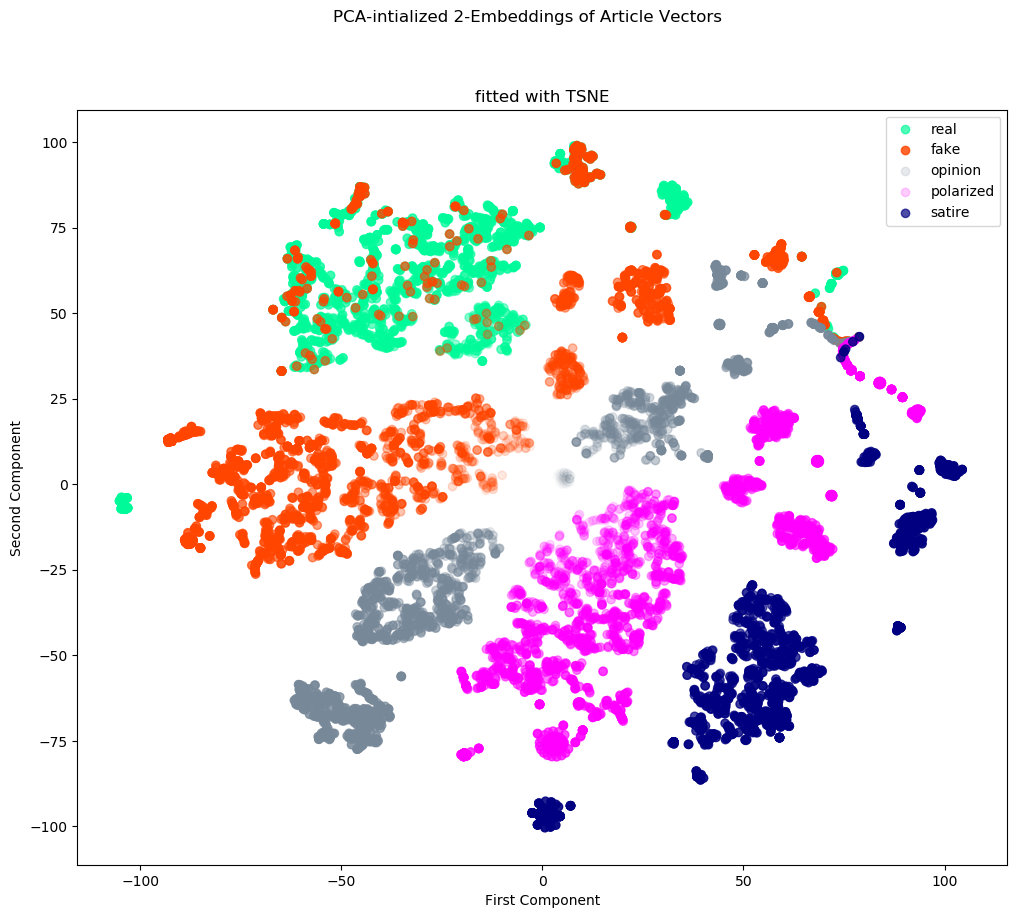

In [5]:
# fitting a TSNE manifold model is time-intensive, so we load a previous embedding if it exists.
list_of_files = glob.glob("./data/*TSNE*.pickle")
latest = max(list_of_files, key=os.path.getctime)
try:
    # open a premade fit
    with open(latest, mode='rb') as filein:
        embedded = pickle.load(filein)
except (IOError, FileNotFoundError):
    # fit on the fly
    tsne_x = TSNE(init='pca', random_state=random_state).fit_transform(x)

# convert to a dataframe if we stored the embeddings as an `ndarray`
if not embedded is pd.core.frame.DataFrame and embedded is np.ndarray:
    x, y, labels = embedded[:,0], embedded[:,1], embedded[:,2]
    embedded = pd.DataFrame({'x':x, 'y':y, 'label':labels})

norms_alpha = pd.DataFrame({'alpha':embedded[['x','y']].apply(np.linalg.norm, axis=1)})
norms_alpha[['label']] = embedded[['label']]
norms_alpha[['alpha']] = MinMaxScaler().fit_transform(norms_alpha[['alpha']].to_numpy().reshape(-1,1))

# we need a mapping of numeric label to string label
# in a moment we will use it to assemble the plot's legend
classdict = dict(zip(model.classes_, ('real', 'fake', 'opinion', 'polarized', 'satire')))

fig, ax = plt.subplots(figsize=(12,10), dpi=100)

cmap = colors.ListedColormap(['mediumspringgreen', 'orangered', 'lightslategrey', 'black', 'fuchsia', 'black', 'navy', 'black'])

for _, (label, classname) in enumerate(classdict.items()):
    
    subset = embedded.query(f'label=={label!s}')
    #color = np.array(cmap(float(label)), ndmin=2)
    color = cmap(subset['label']-1)
    #color = np.repeat(color, len(subset), axis=0)
    #color[:,3] = norms_alpha[norms_alpha['label']==label]['alpha'].to_numpy()
    color[:,3] = norms_alpha[norms_alpha['label']==label]['alpha'].to_numpy()
    x_subset, y_subset = subset['x'], subset['y']
    ax.scatter(x_subset, y_subset,
               label=classname,
               color=color)

ax.legend()
plt.suptitle("PCA-intialized 2-Embeddings of Article Vectors")
plt.title("fitted with TSNE")
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.savefig(f"./figures/TSNE-2_init=PCA_random_state={random_state!s}_classlabels.png", dpi=1000)

There appears to be significant overlap between the `real` and `fake` samples, as the mean class recall scores showed. This separating hyperplane is now one of our primary concerns.

Now that we have TSNE 2-embeddings, we can approximate their natural clusters using K Means clustering. Then we will [obtain the subset of these class samples that demonstrate overlap](https://stackoverflow.com/a/36225714).

Text(0.5, 1.0, 'On PCA Initialized 2-Embeddings of ArticleVectors')

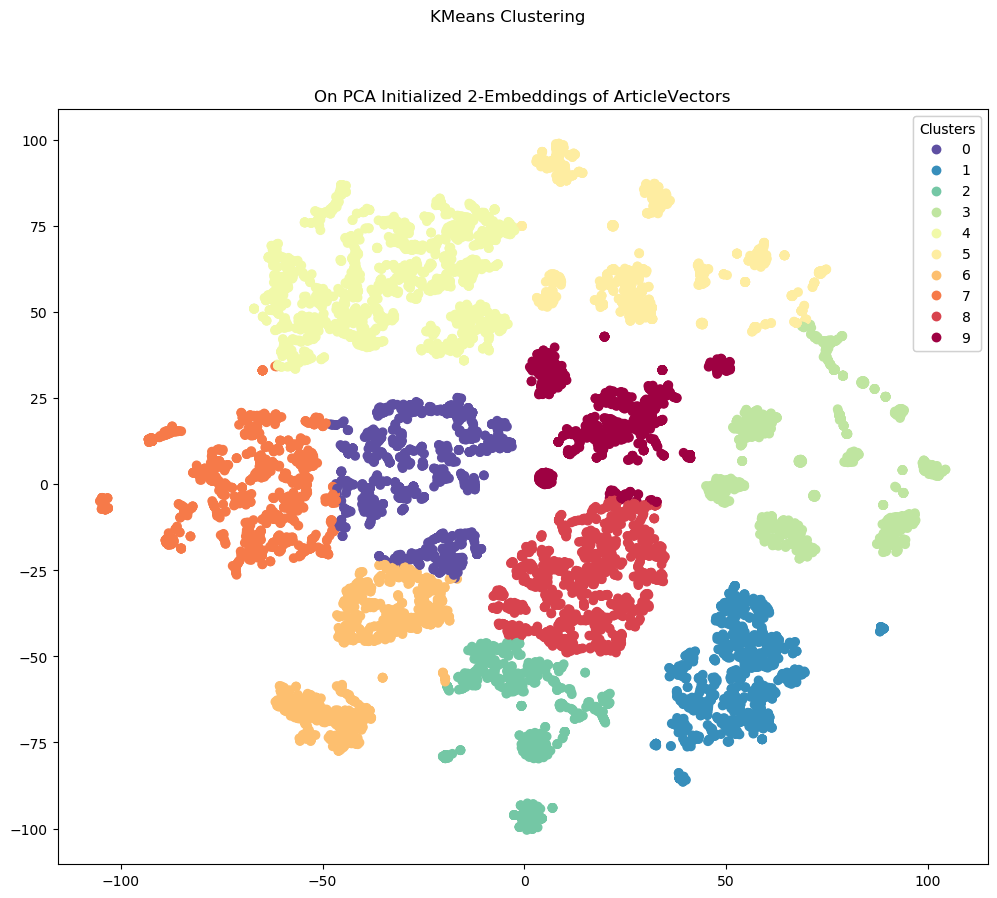

In [6]:
km = KMeans(n_clusters=10, n_jobs=-1, random_state=random_state).fit(embedded)
labels = km.labels_.astype(int)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)

embedded['cluster'] = labels
embedded['index'] = range(len(embedded))

kplot = ax.scatter(embedded['x'], embedded['y'], c=embedded['cluster'], cmap=plt.cm.Spectral_r)
legend = ax.legend(*kplot.legend_elements(),
                    title="Clusters")
ax.add_artist(legend)
plt.suptitle("KMeans Clustering")
plt.title("On PCA Initialized 2-Embeddings of ArticleVectors")

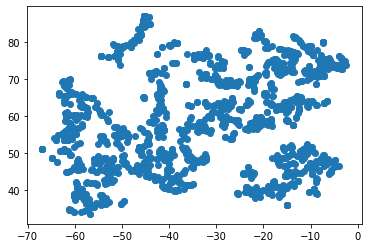

In [7]:
### remember to change the line below to
# match whatever label matches the overlap area
realfake_overlap = embedded[embedded['cluster']==4]
###

# just to show it's the same cluster:
plt.scatter(realfake_overlap['x'], realfake_overlap['y']);

indices = realfake_overlap['index']
# extract these samples from the unembedded data
realfake_overlap = d_subset_robust.iloc[realfake_overlap['index']].reset_index()
realfake_overlap['index'] = indices

Eventually, instead of extracting this chunk visually, I would like to use a function like `np.allclose` on the distances between real and fake samples to extract only samples for which the Euclidean distance is near zero.

In [8]:
realfake_overlap.describe().T

,count,mean,std,min,25%,50%,75%,max
index,1483.0,872.110587,504.177743,0.0,412.500000,902.000000,1300.500000,1713.000000
url_ending_index,1714.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
from_reputable_source_index,1714.0,0.000302,0.002094,0.0,0.000000,0.000000,0.000000,0.066667
grammar_index,1714.0,0.007812,0.022356,0.0,0.000000,0.000000,0.000000,0.200000
quotation_index,1714.0,0.062257,0.037097,0.0,0.035119,0.063353,0.086583,0.185567
past_tense_index,1714.0,0.066677,0.032179,0.0,0.048251,0.066667,0.084626,0.200000
opinion_index,1714.0,0.017969,0.035194,0.0,0.003810,0.010446,0.020716,0.909091
all_caps_index,1714.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
from_satire_source_index,1714.0,0.000728,0.005426,0.0,0.000000,0.000000,0.000000,0.080000
exclamation_index,1714.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [9]:
print(f"Every `url_ending` is 1: {all(realfake_overlap['url_ending_index']==1)!s}")
print(f"Every `all_caps` is 0: {all(realfake_overlap['all_caps_index']==0)!s}")
print(f"Every `exclamation` is 0: {all(realfake_overlap['exclamation_index']==0)!s}")
print(f"Every `from_unreputable_source` is 1: {all(realfake_overlap['from_unreputable_source_index']==1)!s}")
print(f"Count of 0's in `grammar_index`:            {len(realfake_overlap[realfake_overlap['grammar_index']==0])!s} out of {len(realfake_overlap)!s}")
print(f"Count of 0's in `from_satire_source_index`: {len(realfake_overlap[realfake_overlap['from_satire_source_index']==0])!s} out of {len(realfake_overlap)!s}")
print(f"Count of Reals: {len(realfake_overlap[realfake_overlap['label']==1])!s}")
print(f"Count of Fakes: {len(realfake_overlap[realfake_overlap['label']==2])!s}")

Every `url_ending` is 1: True
Every `all_caps` is 0: True
Every `exclamation` is 0: True
Every `from_unreputable_source` is 1: True
Count of 0's in `grammar_index`:            1345 out of 1714
Count of 0's in `from_satire_source_index`: 1540 out of 1714
Count of Reals: 1571
Count of Fakes: 143


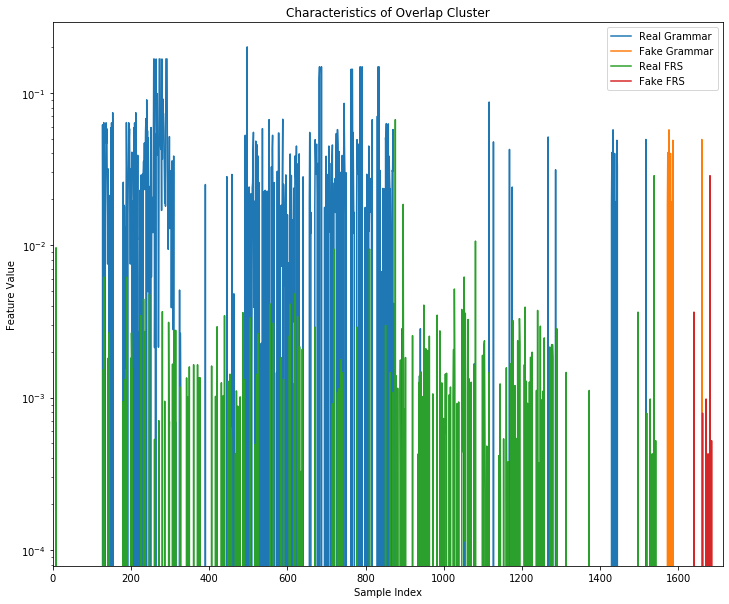

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
realfake_overlap.groupby('label')['grammar_index'].plot(
    ax=ax,
    kind='line',
    logy=True);
realfake_overlap.groupby('label')['from_reputable_source_index'].plot(
    ax=ax,
    kind='line',
    logy=True);
ax.legend(['Real Grammar', 'Fake Grammar', 'Real FRS', 'Fake FRS'], loc='upper right');

plt.ylabel("Feature Value");
plt.xlabel("Sample Index");

plt.title("Characteristics of Overlap Cluster");

We elect to remove all samples where both `grammar_index` is *close* to zero, and there are contradictory source labelings.

In [11]:
tol = (1e-3 - 1e-4)/len(realfake_overlap)
grammar_close_to_zero = np.isclose(a=realfake_overlap['grammar_index'],
                                   b=np.zeros(len(realfake_overlap['grammar_index'])),
                                   atol=tol)

fss_close_to_zero = np.isclose(a=realfake_overlap['from_satire_source_index'],
                               b=np.zeros(len(realfake_overlap['from_satire_source_index'])),
                               atol=tol)

cont_source = np.isclose(
    realfake_overlap['from_reputable_source_index'],
    realfake_overlap['from_unreputable_source_index'],
    atol=tol)

realfake_overlap_subset = realfake_overlap[~cont_source & ~grammar_close_to_zero & ~fss_close_to_zero]

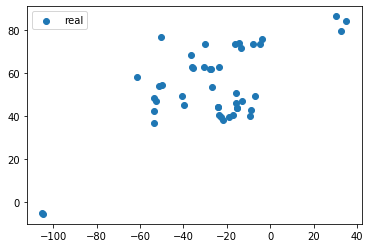

In [12]:
subset = embedded.iloc[realfake_overlap_subset.index.values]

fig, ax = plt.subplots()
ax.scatter(subset['x'], subset['y'],
           label='real' if all(subset['label']==1) else '???')
ax.legend();

This approach, while robust, appears to remove too many samples from the unembedded data. Some alternative strategies include:

* Removing only the fake samples within the overlap cluster.
    * Not recommended – in the real world real and fake news can appear deceivingly close even when viewed through our kernel function that Terence wrote. This is the keystone problem on which this classifier is predicated.
* Engineering new features to help make fake overlaps more distinguishable.
    * This solution is preferred. I am initially unsure of what features would theoretically help us with this – I will once again use the the explication paper and will consult Maria to bring ideas to the table for this.
* Go back to raw text
    * Get sense of whether encoding is the problem or not
    
Web interface – provide input through text box (url or raw) or load input file; Show result – Label + explanation


NEW LABELS by week before spring break

host notebook through nbviewer, rshiny